<a href="https://colab.research.google.com/github/sejongsmarcle/2023_Spring_Kaggle_Study/blob/main/week5/3%ED%8C%80/%EC%A0%95%EC%9C%A0%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
1. Introduction     
2. Imports     
3. Data Loading and Preperation     
    3.1 Exploring Train Data     
    3.2 Exploring Test Data     
    3.3 Submission File     
4. EDA     
    4.1 Overview of Data     
    4.2 Null Value Distribution     
    4.3 Continuos and Categorical Data Distribution     
    4.4 Feature Distribution of Continous Features     
    4.5 Feature Distribution of Categorical Features      
    4.6 Target Distribution     
    4.7 Correlation Matrix     
5. Data Pre-Processing     
6. Modeling     
    6.1 27 Different Classifiers (LAZY PREDICT)     
    6.2 LGBM Classifier      
7. Submission      

# 1. Introduction

이 대회는 Kaggle이 주최하고 Getting Started Prediction Competition 시리즈에 참여하고 있습니다.     
이 대회에서 여러분은 우주선의 손상된 컴퓨터 시스템에서 복구된 기록을 사용하여 변칙성에 의해 어떤 승객이 수송되었는지 예측해야 합니다.     
제출물은 분류 정확도로 평가됩니다.

# 2. Imports

### LazyPredict 설치

In [ ]:
from IPython.display import clear_output # 그림을 그리고 지우는 코드
!pip3 install -U lazypredict
!pip3 install -U # 판다스 업그레이드

clear_output()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px # 파이썬의 시각화 라이브러리
import matplotlib.pyplot as plt
import plotly.graph_objects as go #그래프 그리기
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer # 결측치 대치 파라미터
from sklearn.metrics import accuracy_score # 정확도 평가
from sklearn.preprocessing import LabelEncoder # 문자를 숫자로
from sklearn.model_selection import StratifiedKFold, train_test_split # 교차 검증

from lightgbm import LGBMClassifier
import lazypredict # 머신러닝 자동화 관련 파이썬 오픈소스
from lazypredict.Supervised import LazyClassifier

import time # 시간 데이터
import warnings # 경고 제어
warnings.filterwarnings('ignore')

# 3. Data Loading and Preparation

In [ ]:
train = pd.read_csv("../input/spaceship-titanic/train.csv")
test = pd.read_csv("../input/spaceship-titanic/test.csv")
submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

RANDOM_STATE = 12
FOLDS = 5
STRATEGY = 'median'

### 열 설명
* PassengerId - 각 승객의 고유 ID, gggg : 함께 여행하는 그룹/pp : 그룹 내 번호
* HomePlanet - 승객이 출발한 행성
* CryoSleep - True : cryosleep 상태
* Cabin - 승객이 머무르는 선실 번호, deck/num/side 형식으로 side가 Port = P, Starboard = S
* Destination - 승객이 내릴 행성
* Age - 승객의 나이
* VIP - 특별 VIP 서비스 비용 지불 여부
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 승객이 다양한 편의 시설 각각에 대해 청구한 금액
* Name - 승객의 이름
* Transported - 승객 다른 차원 운송 여부 <- 예측하려는 열

## 3.1 Train 데이터 탐색
* 14개의 열
* 8693개의 행
* 2324개의 누락된 값
* 119378개의 관측치     

12개의 열 모두 누락된 값O, CryoSleep에서 누락된 값 가장 높음
Transported는 Train 데이터 세트에만 사용가능

### Train 데이터 보기

처음 5개 행

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [ ]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


### 열 결측값

In [ ]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


### Train 데이터의 기본 통계

개수, 평균, 표준 편차, 최소값, 25%, 50%, 75%, 최대값에 대한 정보

In [ ]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


## 3.2 Test 데이터 탐색
* 13개의 열
* 4277개의 행
* 1117개의 누락된 값
* 54484개의 관측치     

12개의 열 모두 누락된 값O, FoodCourt에서 누락된 값 가장 높음

### Test 데이터 보기

In [ ]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


In [ ]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in test data: {test.count().sum()}')
print(f'\033[94No of rows with missing values in test data: {sum(test.isna().sum())}')

Number of rows in test data: 4277
Number of columns in test data: 13
Number of values in test data: 54484
o of rows with missing values in test data: 1117


### 열 결측값

In [ ]:
print(f'\033[94m')
print((test.isna().sum().sort_values(ascending = False)))


FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


### Test 데이터의 기본 통계

개수, 평균, 표준 편차, 최소값, 25%, 50%, 75%, 최대값에 대한 정보

In [ ]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


## 3.3 Submission File

### Submission File 보기

In [ ]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


## 4. EDA

## 4.1 데이터 개요

In [ ]:
train.drop(["PassengerId"], axis = 1, inplace = True)
test.drop(["PassengerId"], axis = 1, inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12

In [ ]:
train.iloc[:, :-1].describe().T.sort_values(by='std', ascending = False)\
    .style.background_gradient(cmap='GnBu')\
    .bar(subset=["max"], color = '#BB0000')\
    .bar(subset=["mean"], color = 'grean')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


## 4.2 Null Value Distribution

Null 값 분포의 관찰 :     
* 행 결측값의 최대값은 3, 최소값은 X
* 누락된 값 분포 (행 기준) Train, Test 데이터 셋 비슷
* 누락된 값 없는 관측치 (행 기준) 약 76%
* 누락된 값 있는 관측치는 (행 기준) 24%

### 열 별 Null값 분포

In [ ]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0, ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0, ascending = False)[:-1]

fig = make_subplots(rows=1, cols=2, column_titles = ["Train Data", "Test Data"],
                   x_title = "Missing Values")

fig.add_trace(go.Bar(x=train_null[0], y=train_null.index, orientation="h", marker=dict(color=[n for n in range(12)], line_color='rgb(0, 0, 0)', line_width=2, coloraxis="coloraxis")), 1, 1)
fig.add_trace(go.Bar(x=test_null[0], y=test_null.index, orientation="h", marker=dict(color=[n for n in range(12)], line_color='rgb(0, 0, 0)', line_width=2, coloraxis="coloraxis")), 1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

### 행 별 Null값 분포

In [ ]:
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100

fig = make_subplots(rows=1, cols = 2, column_titles = ["Train Data", "Test Data"], 
                    x_title = "Missing Values")
fig.add_trace(go.Bar(x=missing_train_row["no"], y=missing_train_row["count"], marker=dict(color=[n for n in range(4)], line_color='rgb(0,0,0)', line_width=3, coloraxis="coloraxis")), 1,1)
fig.add_trace(go.Bar(x=missing_test_row["no"], y=missing_test_row["count"], marker=dict(color=[n for n in range(4)], line_color='rgb(0,0,0)', line_width=3, coloraxis="coloraxis")), 1,2)
fig.update_layout(showlegend=False, title_text = "Row wise Null Value Distribution", title_x=0.5)

### 누락된 값 처리
몇 가지 참고 자료     

* Missing Values by Alexis Cook
* Data Cleaning Challenge: Handling missing values by Rachael Tatman
* A Guide to Handling Missing values in Python by Parul Pandey

기본적으로 누락된 값을 처리하는 기능이 있는 일부 모델      
* XGBoost: https://xgboost.readthedocs.io/en/latest/faq.html
* LightGBM: https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html
* Catboost: https://catboost.ai/docs/concepts/algorithm-missing-values-processing.html

## 4.3 Continuos and Categorical Data Distribution

Null값 분포의 관찰
* 12개의 features 중 6개는 연속형, 2개는 텍스트 데이터, 4개는 범주형
* HomePlanet과 Destination에는 3개의 서로 다른 고유값 존재
* CryoSleep과 VIP는 bool features

In [ ]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis = 0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

labels = ['Categorical', 'Continuos', "Text"]
values = [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data = [go.Pie(labels=labels, values = values, pull = [0.1,0,0], marker=dict(colors=colors, line=dict(color='#000000', width=2)))])
fig.show()

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


## 4.4 Feature Distribution of Continuous Features

연령 분포

In [ ]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, x="Age", color="type", color_discrete_sequence = ['#58D68D', '#DE3163'], marginal="box", nbins=100, template="plotly_white")
fig.update_layout(title = "Distribution of Age", title_x = 0.5)
fig.show()

## 4.5 Feature Distribution of Categorical Features

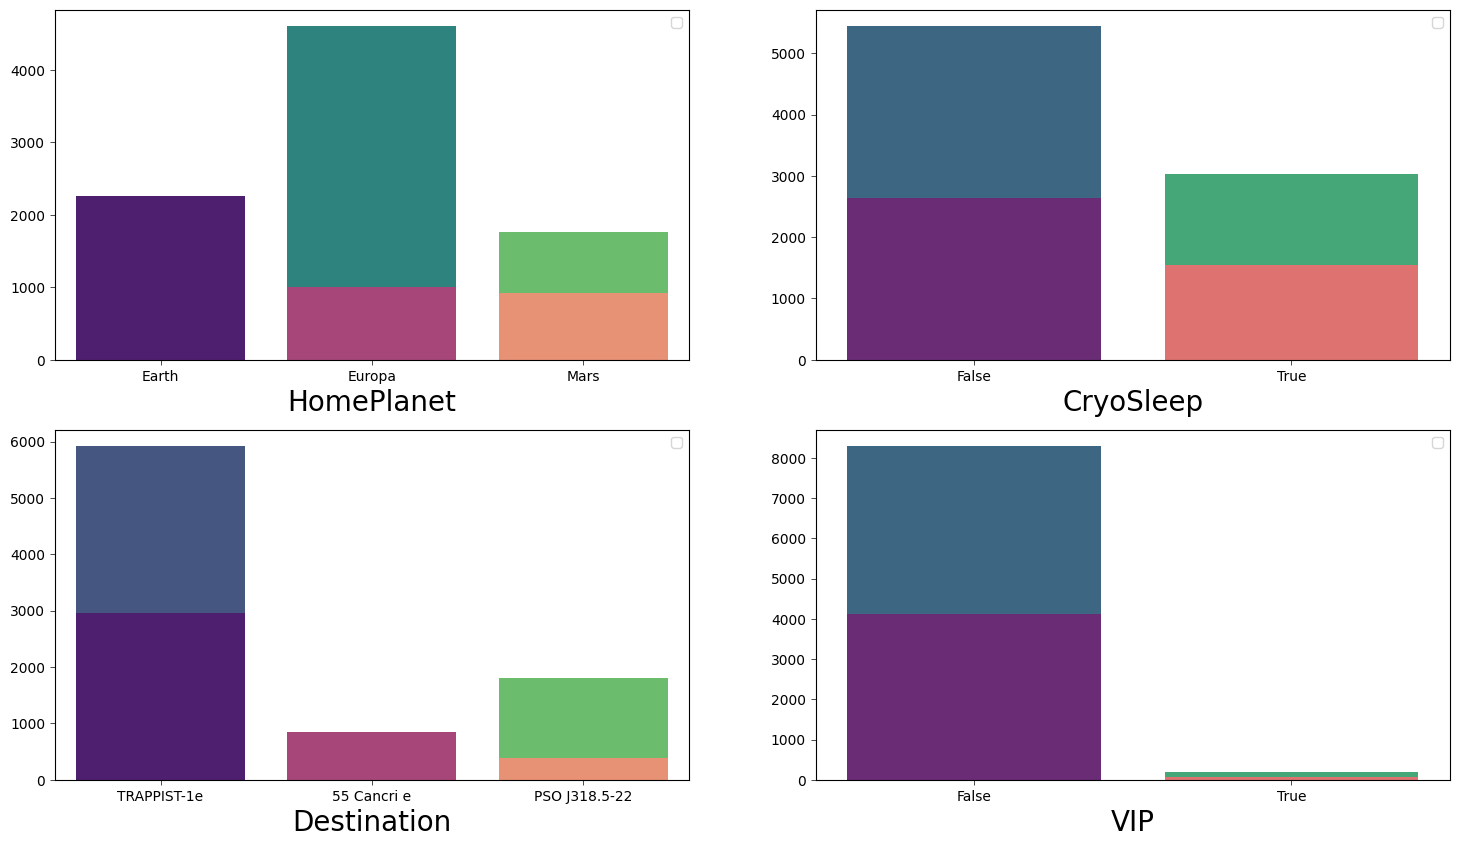

In [ ]:
if len(cat_features) == 0:
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col], ax = axes[r,c], x=train[col], palette="viridis")
            sns.countplot(test[col], ax = axes[r,c], x=test[col], palette="magma") # 오류 나길래 x값에 열 넣었더니 해결
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

## 4.6 Target Distribution

Null값 분포의 관찰
* 대상 : 0, 1
* 0과 1이 거의 균등하게 분포

In [ ]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame = target_df, x = TARGET, y = 'count')
fig.update_traces(marker_color = ['#58D68D', '#DE3163'], marker_line_color='rgb(0,0,0)', marker_line_width=2, )

fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0]*100/train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]*100/train.shape[0]))
fig.show()

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


## 4.7 Correlation matrix

In [ ]:
fig = px.imshow(train.corr(), text_auto=True, aspect="auto", color_continuous_scale = "viridis")
fig.show()

# 5. Data Pre-Processing

누락된 값 대치

In [ ]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]
imputer = SimpleImputer(strategy = STRATEGY)
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace=True)
test["HomePlanet"].fillna('Z', inplace=True)

### 범주형 인코딩

In [ ]:
label_cols = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

train, tset = label_encoder(train, test, label_cols)

In [ ]:
train.drop(["Name", "Cabin"], axis = 1, inplace = True)
test.drop(["Name", "Cabin"], axis = 1, inplace = True)
X = train.drop(TARGET, axis = 1)
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12, test_size = 0.33)